### Fig. S3: Investigation of most abundant proteins across cycles and their correlations to isoprenol titer

#### Notebook overview
- Import libraries
- Import data
- Set Figure_Data folder for import
- Set Figure_Export folder for plots
- Translate gene names into locus names
- <b> Set default analysis to DBTL0 only </b>

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import linregress
from scipy.stats import spearmanr

In [2]:
input_dir = r'Figure_Data'
output_dir = r'Figure_Export'

In [3]:
# Incorporates all DBTL cycles
filenames = [f'DBTL{0}.csv' for i in range(7)]
input_paths = [os.path.join(input_dir, filename) for filename in filenames]

# Load CSVs and concatenate multiple files if necessary
dataframes = [pd.read_csv(input_path) for input_path in input_paths]
proteomics_df = pd.concat(dataframes, ignore_index=True)

isoprenol_df = pd.read_csv('Figure_Data/250317_All_Data.csv')
proteomics_df['Line Name'] = proteomics_df['Sample'] + '-' + proteomics_df['Replicate'].astype(str)

#### Only looking at the data in DBTL0

In [4]:
isoprenol_df = isoprenol_df[ (isoprenol_df['cycle'] == 0)]

In [5]:
# isoprenol_df = isoprenol_df[(isoprenol_df['to_keep_improved'] == True)]

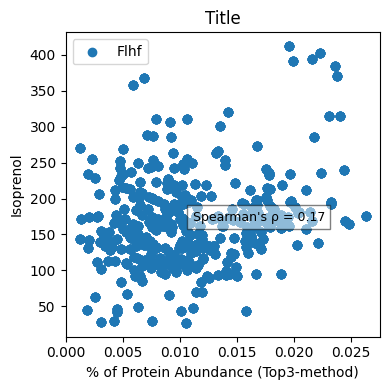

In [6]:
proteins_of_interest = ['Flhf']
filtered_proteomics_df = proteomics_df[proteomics_df['Protein'].isin(proteins_of_interest)]

# Merge the two DataFrames on the "Line Name" column
merged_df = pd.merge(filtered_proteomics_df, isoprenol_df, on='Line Name')
merged_df = merged_df[(merged_df['%_of protein_abundance_Top3-method'] != 0) &
                      (merged_df['isoprenol'] != 0) &
                      (merged_df['%_of protein_abundance_Top3-method'] >= 0.001) &
                      (merged_df['isoprenol'] >= 10)]

# Plotting
plt.figure(figsize=(4, 4))
for protein in proteins_of_interest:
    protein_df = merged_df[merged_df['Protein'] == protein]
    if not protein_df.empty:
        plt.scatter(protein_df['%_of protein_abundance_Top3-method'], protein_df['isoprenol'], label=f"{protein}")
        
        # Calculate Spearman's correlation coefficient and p-value
        spearman_corr, p_value = spearmanr(protein_df['%_of protein_abundance_Top3-method'], protein_df['isoprenol'])
        
        # Display Spearman's correlation coefficient on the plot
        plt.text(protein_df['%_of protein_abundance_Top3-method'].mean(), 
                 protein_df['isoprenol'].mean(), 
                 f"Spearman's ρ = {spearman_corr:.2f}", 
                 fontsize=9, 
                 bbox=dict(facecolor='white', alpha=0.5))
    else:
        print(f"No data found for protein: {protein}")

plt.xlabel('% of Protein Abundance (Top3-method)')
plt.ylabel('Isoprenol')
plt.title('Title')
plt.legend()
plt.tight_layout()
plt.show()

#### Setting thresholds for protein abundance and isoprenol titer

In [ ]:
# Merge the two DataFrames on the "Line Name" column
merged_df = pd.merge(proteomics_df, isoprenol_df, on='Line Name')

# Filter out rows where the relevant columns are zero or below the specified thresholds
filtered_df = merged_df[(merged_df['%_of protein_abundance_Top3-method'] != 0) &
                        (merged_df['isoprenol'] != 0) &
                        (merged_df['%_of protein_abundance_Top3-method'] >= 0.001) &
                        (merged_df['isoprenol'] >= 10)]

# Initialize a list to store results
results = []

# Iterate through each protein in proteomics_df
for protein in proteomics_df['Protein'].unique():
    protein_df = filtered_df[filtered_df['Protein'] == protein]
    
    if not protein_df.empty:
        # Calculate Spearman's correlation coefficient
        spearman_corr, p_value = spearmanr(protein_df['%_of protein_abundance_Top3-method'], protein_df['isoprenol'])
        
        # Calculate the average % abundance in "Control" strains
        control_df = protein_df[protein_df['Sample'] == 'Control']
        avg_abundance = control_df['%_of protein_abundance_Top3-method'].mean()
        
        # Append the results to the list
        results.append({
            'Protein': protein,
            'Spearman_Correlation': spearman_corr,
            'Average_Abundance_Control': avg_abundance
        })
    else:
        results.append({
            'Protein': protein,
            'Spearman_Correlation': None,
            'Average_Abundance_Control': None
        })

# Convert the results list to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

#### Save Spearman rank correlation coefficients to a .csv file

In [ ]:
results_df.to_csv('Figure_Export//Coefficients_DBTL0.csv', index=False)

#### Plot the top fifty by average abundance in the control
- This is to visualize how the most abundant proteins compare to isoprenol titer

In [ ]:
# Sort by average abundance and select top 50 proteins
top_50_proteins = results_df.sort_values(by='Average_Abundance_Control', ascending=False).head(50)

# Plotting
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(6.5, 9), sharex=False, sharey=True)
axes = axes.flatten()

# Set the font family to Arial and the font size to 7
plt.rcParams.update({'font.size': 5})

for i, protein in enumerate(top_50_proteins['Protein']):
    protein_df = filtered_df[filtered_df['Protein'] == protein]
    ax = axes[i]
    sns.scatterplot(x='%_of protein_abundance_Top3-method', y='isoprenol', data=protein_df, ax=ax, s=10,linewidth=0.05)
    spearman_corr = top_50_proteins[top_50_proteins['Protein'] == protein]['Spearman_Correlation'].values[0]
    avg_abundance = top_50_proteins[top_50_proteins['Protein'] == protein]['Average_Abundance_Control'].values[0]
    
    # Set text color based on Spearman correlation value
    spearman_color = 'green' if spearman_corr > 0 else 'red'
    
    ax.set_title(f'{protein}\nAvg Abundance: {avg_abundance:.2f}%', fontsize=5)
    ax.text(0.5, 0.8, f'Spearman:\n {spearman_corr:.2f}', color=spearman_color, ha='center', va='center', 
            transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', linewidth = 0.1, boxstyle='round,pad=0.5',alpha = 0.5))
    ax.set_xlabel('% Protein abundance', fontsize=5)
    ax.set_ylabel('Isoprenol titer (mg/L)', fontsize=5)
        
    # Set x-axis limits and custom ticks
    x_min = protein_df['%_of protein_abundance_Top3-method'].min()
    x_max = protein_df['%_of protein_abundance_Top3-method'].max()
    ax.set_xlim(x_min, x_max)
    ax.set_xticks([x_min, x_max])
    ax.tick_params(axis='both', which='major', labelsize=5)

# Adjust layout
plt.tight_layout()
# Save the figure to a PDF file
fig.savefig('Figure_Export//top_50_proteins_scatterplots.pdf', format='pdf')

plt.show()